In [ ]:
import pandas as pd
import json
import sqlite3
from google.colab import drive

# 1. Mount Drive and define path
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DELI-CORE/'

# 2. Load JSON
with open(path + 'users.json', 'r') as f:
    df_users = pd.DataFrame(json.load(f))

# 3. Load CSV
df_orders = pd.read_csv(path + 'orders.csv')

# 4. Load SQL
conn = sqlite3.connect(':memory:')
with open(path + 'restaurants.sql', 'r') as f:
    conn.executescript(f.read())
df_restaurants = pd.read_sql_query("SELECT * FROM restaurants", conn)

print("Raw data loaded from all 3 sources.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw data loaded from all 3 sources.


In [ ]:
# A. Integrity
print("REPORT:")
print(f"- Missing Values: {df_orders.isnull().sum().sum() + df_users.isnull().sum().sum()} found.")
print(f"- Duplicate Orders: {df_orders.duplicated().sum()} found.")

# B. Standardizing Text
df_users['city'] = df_users['city'].str.strip().str.title()
df_users['membership'] = df_users['membership'].str.strip().str.capitalize()
df_restaurants['cuisine'] = df_restaurants['cuisine'].str.strip().str.title()

# C. Fixing Types
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'], dayfirst=True)
df_orders['user_id'] = df_orders['user_id'].astype(int)
df_orders['restaurant_id'] = df_orders['restaurant_id'].astype(int)

# D. Schema Alignment
df_orders.rename(columns={'restaurant_name': 'raw_order_name'}, inplace=True)

print("\nData cleaned, audited, and standardized.")

Data Cleaned.


In [26]:
# 1. Primary Join: Orders (Left) + Users (Right)
df_merged = pd.merge(df_orders, df_users, on='user_id', how='left')

# 2. Secondary Join: Result (Left) + Restaurants (Right)
df_final = pd.merge(df_merged, df_restaurants, on='restaurant_id', how='left')

# 3. Handle the Naming Conflict Logic
if 'restaurant_name' in df_final.columns and 'raw_order_name' in df_final.columns:
    df_final['restaurant_name'] = df_final['restaurant_name'].fillna(df_final['raw_order_name'])

    # 4. Clean up the temporary column
    df_final.drop(columns=['raw_order_name'], inplace=True)

# 5. Export the 'Golden Dataset' to your Drive
output_file = path + 'final_delivery_analysis_dataset.csv'
df_final.to_csv(output_file, index=False)

print(f"Total rows in final dataset: {len(df_final)}")
print(f"master file is saved at: {output_file}")

# Show the columns to verify 'restaurant_name' exists now
print("\nFinal Column List:", df_final.columns.tolist())
df_final.head()

Total rows in final dataset: 10000
master file is saved at: /content/drive/MyDrive/DELI-CORE/final_delivery_analysis_dataset.csv

Final Column List: ['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount', 'restaurant_name_x', 'name', 'city', 'membership', 'restaurant_name_y', 'cuisine', 'rating']


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [27]:
# --- 1. Calculate Core KPIs ---
total_revenue = df_final['total_amount'].sum()
avg_order_value = df_final['total_amount'].mean()
total_orders = len(df_final)
avg_rating = df_final['rating'].mean()

# --- 2. Print a Professional Summary Table ---
print(f"{'='*40}")
print(f"📊 EXECUTIVE SUMMARY REPORT")
print(f"{'='*40}")
print(f"💰 Total Revenue Generated:  ₹{total_revenue:,.2f}")
print(f"🛒 Total Orders Processed:   {total_orders:,}")
print(f"📈 Average Order Value:      ₹{avg_order_value:.2f}")
print(f"⭐ Average Customer Rating:  {avg_rating:.2f} / 5.0")
print(f"{'='*40}")

📊 EXECUTIVE SUMMARY REPORT
💰 Total Revenue Generated:  ₹8,011,624.12
🛒 Total Orders Processed:   10,000
📈 Average Order Value:      ₹801.16
⭐ Average Customer Rating:  4.05 / 5.0


/tmp/ipython-input-2957625207.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_rev.index, y=city_rev.values, palette='viridis')


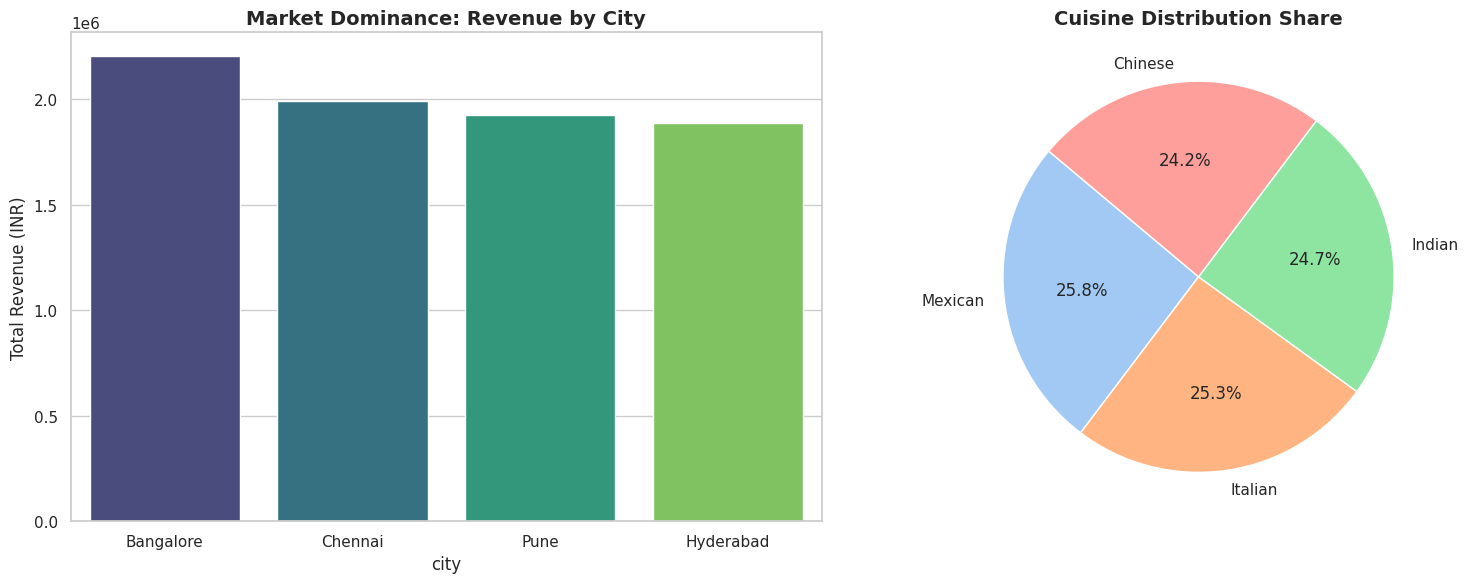

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 6))

# Subplot 1: Revenue by City
plt.subplot(1, 2, 1)
city_rev = df_final.groupby('city')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=city_rev.index, y=city_rev.values, palette='viridis')
plt.title('Market Dominance: Revenue by City', fontsize=14, fontweight='bold')
plt.ylabel('Total Revenue (INR)')

# Subplot 2: Popularity of Cuisines
plt.subplot(1, 2, 2)
cuisine_counts = df_final['cuisine'].value_counts()
plt.pie(cuisine_counts, labels=cuisine_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=140)
plt.title('Cuisine Distribution Share', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2145970815.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='membership', y='total_amount', palette='magma')


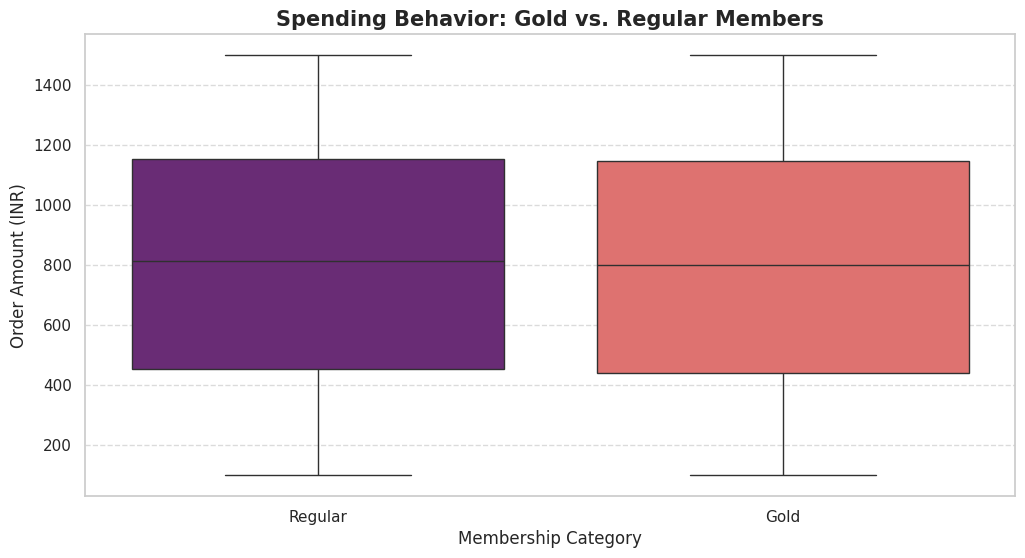


📝 Membership Statistical Insight:
             count        mean         std
membership                                
Gold        4987.0  797.145556  407.386619
Regular     5013.0  805.158434  403.532709


In [29]:
plt.figure(figsize=(12, 6))

# Comparative Analysis: Spend Distribution by Membership
sns.boxplot(data=df_final, x='membership', y='total_amount', palette='magma')

plt.title('Spending Behavior: Gold vs. Regular Members', fontsize=15, fontweight='bold')
plt.xlabel('Membership Category')
plt.ylabel('Order Amount (INR)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Quick Statistical Insight
membership_stats = df_final.groupby('membership')['total_amount'].describe()[['count', 'mean', 'std']]
print("\n📝 Membership Statistical Insight:")
print(membership_stats)

/tmp/ipython-input-3291750196.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_final['order_date'] = pd.to_datetime(df_final['order_date'])


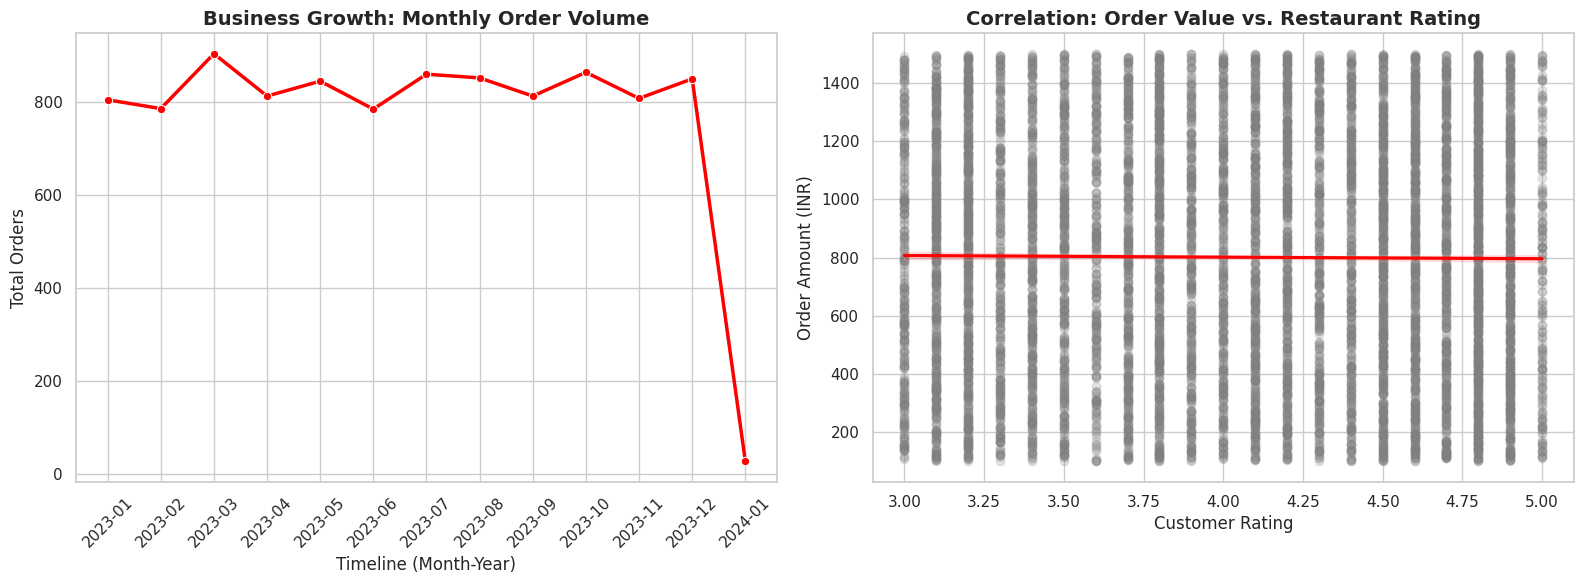

📈 Growth Insight: The busiest month was 2023-03 with 903 orders.


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Robust Time-Series Preparation ---
df_final['order_date'] = pd.to_datetime(df_final['order_date'])

# Extracting Month-Year for the trend line
df_final['month_year'] = df_final['order_date'].dt.to_period('M').astype(str)
monthly_trend = df_final.groupby('month_year').size()

plt.figure(figsize=(16, 6))

# Subplot 1: Business Scalability (Growth Trend)
plt.subplot(1, 2, 1)
monthly_trend = monthly_trend.sort_index()
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values, marker='o', color='red', linewidth=2.5)

plt.title('Business Growth: Monthly Order Volume', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel('Timeline (Month-Year)')
plt.ylabel('Total Orders')

# Subplot 2: Correlation Analysis (Value vs. Rating)
plt.subplot(1, 2, 2)
sns.regplot(data=df_final, x='rating', y='total_amount',
            scatter_kws={'alpha':0.2, 'color':'gray'},
            line_kws={'color':'red'})

plt.title('Correlation: Order Value vs. Restaurant Rating', fontsize=14, fontweight='bold')
plt.xlabel('Customer Rating')
plt.ylabel('Order Amount (INR)')

plt.tight_layout()
plt.show()

# Quick Insight Printing
print(f"📈 Growth Insight: The busiest month was {monthly_trend.idxmax()} with {monthly_trend.max()} orders.")